In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dataset_path = "gdrive/MyDrive/Root/feature_set_v5.pickle"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras import regularizers, initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
import seaborn as sns
import pandas as pd
import numpy as np
import numpy.random
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
df=[] # Import data
with open(dataset_path, "rb") as f:
    df=(pickle.load(f))
df.head(7)

,AllFeatures,AvgElo,DiffElo
0,"[0.0, 1.0, 0.25862068965517243, 0.0, 0.75, 0.4...",1172.0,-20
1,"[0.0, 1.0, 0.20689655172413793, 0.0, 0.0, 0.40...",1172.5,-1
2,"[0.0, 1.0, 0.3333333333333333, 0.0, 1.0, 0.471...",1170.0,-38
3,"[0.0, 1.0, 0.07692307692307693, 0.0, 0.0, 0.26...",1173.0,-44
4,"[0.0, 1.0, 0.3157894736842105, 0.0, 1.0, 0.464...",1171.5,37
5,"[0.0, 1.0, 0.35135135135135137, 0.0, 1.0, 0.47...",1172.0,8
6,"[0.0, 1.0, 0.3, 0.0, 0.75, 0.45825756949558394...",1168.5,27


In [ ]:
df = df[(df["AvgElo"]>1400)&(df["AvgElo"]<1900)]
df = df[(abs(df["DiffElo"])<100)]

count    35470.000000
mean      1629.967212
std        263.381036
min       1168.500000
25%       1403.000000
50%       1631.500000
75%       1858.000000
max       2083.000000
Name: AvgElo, dtype: float64


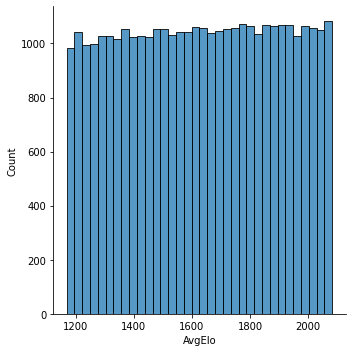

In [ ]:
sns.displot(df["AvgElo"])
print(df["AvgElo"].describe())

In [ ]:
np.arange(1300, 1900, 10)

In [ ]:
df=df.sort_values(by="AvgElo")



In [ ]:
AAA1=df[["AvgElo","DiffElo"]]


In [ ]:
df.iterrows()

TypeError: ignored

In [ ]:
mino=1300.5
maxo=1899.5

leng=int(2*(maxo-mino+1))
leng2=199
k=np.zeros([leng,leng2])

for row in df.itertuples():
  i=row[2]
  e=row[3]

  k[2*int(i-1300.5),int(e)+99]+=1


In [ ]:
k


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
I=np.nonzero(k)
kuk=np.zeros(leng)
kuk[I]=1/k[I]

In [ ]:
kuk=kuk/sum(kuk)

In [ ]:
newdf=df


In [ ]:
k = np.arange(1400, 1900, 10)
datas = []
for i, e in enumerate(k):
  if i==0:
    continue
  datas.append(df[((df["AvgElo"]>=k[i-1]) & (df["AvgElo"]<e))])

In [ ]:
p=0
Pm=9999
for e in datas:
  p = max(p,len(e))
  Pm = min(Pm, len(e))
print(Pm)
 
  
for i,e in enumerate(datas):
  if len(e)>Pm:
    datas[i] =  e.sample(Pm)
df=pd.concat(datas)

289


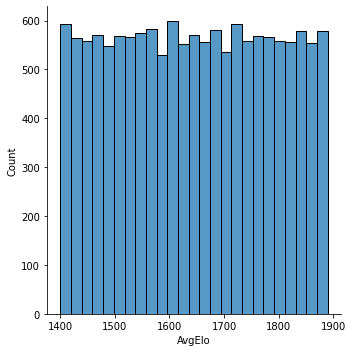

In [ ]:
sns.displot(df["AvgElo"])

In [ ]:
x = StandardScaler().fit_transform(np.array(df["AllFeatures"].tolist()))
pca = PCA(n_components=2)
principalComponents = np.array(df["AllFeatures"].tolist()) #pca.fit_transform(x)#

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


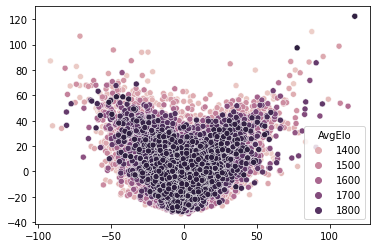

In [ ]:
sns.scatterplot(principalComponents[:,0], principalComponents[:,1], hue=df["AvgElo"])

In [ ]:
outputs = np.asarray(df["AvgElo"])
outputs = np.append(outputs[np.newaxis].transpose(), np.asarray(df["DiffElo"])[np.newaxis].transpose(), axis=1)
dataset = np.concatenate([principalComponents, outputs], axis=1)

In [ ]:
print(principalComponents.shape, dataset.shape)

(35470, 2845) (35470, 2847)


In [ ]:
np.random.shuffle(dataset)
train = dataset[:len(dataset)//285*256]
test = dataset[len(dataset)//285*256:]
trainX = train[:,:len(principalComponents[0])]
trainY = train[:,len(principalComponents[0]):]
testX = test[:,:len(principalComponents[0])]
testY = test[:,len(principalComponents[0]):]

In [ ]:
models=[]

In [ ]:
checkpoint_name = 'gdrive/MyDrive/Root/ckpt.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_MAE', verbose = 1, save_best_only = True, mode ='auto')
stop = EarlyStopping(monitor='val_MAE', patience=30)
callbacks_list = [checkpoint, stop]
initializer = initializers.GlorotUniform()
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(int(2*(len(trainX[0])**2)**(1/3)), input_dim=len(trainX[0]), kernel_regularizer=regularizers.l2(0.002), kernel_initializer=initializer))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(int(2*(len(trainX[0]))**(1/3)), activation='linear', kernel_initializer=initializer))
model.add(Dense(2))
model.compile(loss="mean_squared_error", optimizer='adam', metrics=['MAE'])
model.fit(trainX, trainY, epochs=1000, batch_size=1024, validation_split=0.1, callbacks=callbacks_list)
model.load_weights(checkpoint_name)
models.append(model)

Epoch 1/1000
28/28 [==============================] - 1s 20ms/step - loss: 1358685.3664 - MAE: 826.3548 - val_loss: 1560037.8750 - val_MAE: 887.7173

Epoch 00001: val_MAE improved from inf to 887.71735, saving model to gdrive/MyDrive/Root/ckpt.hdf5
Epoch 2/1000
28/28 [==============================] - 0s 13ms/step - loss: 1338776.2931 - MAE: 822.8168 - val_loss: 1296259.6250 - val_MAE: 805.5917

Epoch 00002: val_MAE improved from 887.71735 to 805.59174, saving model to gdrive/MyDrive/Root/ckpt.hdf5
Epoch 3/1000
28/28 [==============================] - 0s 13ms/step - loss: 1315212.4397 - MAE: 816.4913 - val_loss: 1065866.2500 - val_MAE: 729.4282

Epoch 00003: val_MAE improved from 805.59174 to 729.42816, saving model to gdrive/MyDrive/Root/ckpt.hdf5
Epoch 4/1000
28/28 [==============================] - 0s 13ms/step - loss: 1260259.9267 - MAE: 799.5542 - val_loss: 963043.3750 - val_MAE: 695.7471

Epoch 00004: val_MAE improved from 729.42816 to 695.74707, saving model to gdrive/MyDrive/Ro

In [ ]:
for q in [0.1, 0.2, 0.3, 0.7, 0.8, 0.9]:
  def tilted_loss(y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)
  checkpoint_name = 'gdrive/MyDrive/Root/ckpt.hdf5' 
  checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
  stop = EarlyStopping(monitor='val_loss', patience=10)
  callbacks_list = [checkpoint, stop]
  initializer = initializers.GlorotUniform()
  model = Sequential()
  model.add(BatchNormalization())
  model.add(Dense(int(2*(len(trainX[0])**2)**(1/3)), input_dim=len(trainX[0]), kernel_regularizer=regularizers.l2(0.001), kernel_initializer=initializer))
  model.add(LeakyReLU(alpha=0.3))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(int(2*(len(trainX[0]))**(1/3)), activation='linear', kernel_initializer=initializer))
  model.add(Dense(2))
  model.compile(loss=tilted_loss, optimizer='adam', metrics=['MAE'])
  model.fit(trainX, trainY, epochs=1000, batch_size=1024, validation_split=0.1, callbacks=callbacks_list)
  model.load_weights(checkpoint_name)
  models.append(model)

In [ ]:
model_pred = model.predict(testX)
elo_pred = np.array([model_pred[:,0] + model_pred[:,1] / 2, model_pred[:,0] - model_pred[:,1] / 2])
elo_real = np.array([testY[:,0] + testY[:,1] / 2, testY[:,0] - testY[:,1] / 2])

In [ ]:
real = elo_real[0, :]<df["AvgElo"].mean()
pred = elo_pred[0, :]<df["AvgElo"].mean()
Confusion = [sum((real) & (pred)), sum((real) & (~pred)), sum((~real) & (pred)), sum((~real) & (~pred))] 
print(Confusion, (Confusion[0]+Confusion[3])/sum(Confusion))

[1499, 319, 393, 1515] 0.8089103596349974


In [ ]:
models


In [ ]:
models = models[:1]

## Multi Model Predictions

In [ ]:
elo_real = np.array([testY[:,0] + testY[:,1] / 2, testY[:,0] - testY[:,1] / 2])
 
cutoff = 0
model_pred_mean = model.predict(testX)
#model_pred_max = models[-cutoff-1].predict(testX)
#model_pred_min = models[cutoff+1].predict(testX)
 
#elo_max = np.array([model_pred_max[:,0] + model_pred_max[:,1] / 2, model_pred_max[:,0] - model_pred_min[:,1] / 2])
#elo_min = np.array([model_pred_min[:,0] + model_pred_min[:,1] / 2, model_pred_min[:,0] - model_pred_max[:,1] / 2])
 
elo_pred_mean = np.array([model_pred_mean[:,0] + model_pred_mean[:,1] / 2, model_pred_mean[:,0] - model_pred_mean[:,1] / 2])
 
#elo_uncertainty = (elo_max-elo_min)[0, :]
#elo_uncertainty = (model_pred_max[:, 0] - model_pred_min[:, 0]) + (model_pred_max[:, 1] - model_pred_min[:, 1])/2
#elo_uncertainty_black = (model_pred_max[:, 0] - model_pred_min[:, 0]) - (model_pred_min[:, 1] - model_pred_max[:, 1])/2print(elo_uncertainty)

In [ ]:
conf = [x in np.random.choice(elo_real[0,:], 10) for x in elo_real[0, :]]

In [ ]:
testY[:, 0]

array([1869.5, 1643. , 1813.5, ..., 1513.5, 1472.5, 1728.5])

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=4, n_estimators=250, learning_rate=0.05, verbose=2)
xgb.fit(trainX, trainY[:,0])
xp = xgb.predict(testX)

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[16:58:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(1000.0, 2200.0)

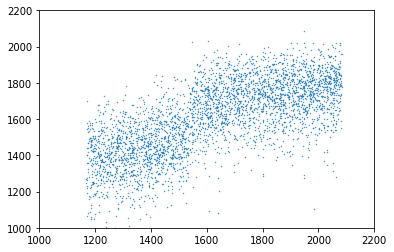

In [ ]:
pyplot.scatter(testY[:, 0], model_pred_mean[:,0], s=0.15)
pyplot.ylim(1000,2200)
pyplot.xlim(1000,2200)

                 0
count  7257.000000
mean    719.595947
std      92.237885
min     407.719360
25%     658.097412
50%     712.581909
75%     771.067871
max    1446.694824


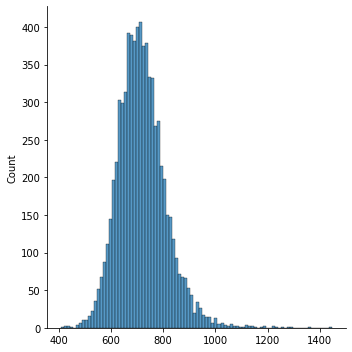

In [ ]:

sns.displot(elo_uncertainty)
print(pd.DataFrame(elo_uncertainty).describe())

In [ ]:
interval = np.array([elo_pred_mean-elo_uncertainty/2, elo_pred_mean+elo_uncertainty/2])
np.sum((interval[0,:]<=elo_real) & (interval[1,:]>=elo_real), axis=1)/elo_real.shape[1]

array([0.91732121, 0.91291167])

In [ ]:
np.sum((elo_min < elo_real)&(elo_real < elo_max), axis=1)/len(testY)

array([0.91277387, 0.91139589])

In [ ]:
conf = elo_real>0
 
real_conf = testY
pred_conf =model_pred_mean
 
print(np.sum(conf), sum(abs(real_conf - pred_conf)< 100)/sum(conf))
#interval = np.array([elo_pred_mean[0,:][conf]-elo_uncertainty[conf]/2, elo_pred_mean[0,:][conf]+elo_uncertainty[conf]/2])
#print(np.sum(conf), np.sum((interval[0,:]<=elo_real[0,:][conf]) & (interval[1,:]>=elo_real[0,:][conf]))/elo_real[0,:][conf].shape[0])

ValueError: ignored

In [ ]:
elo_real[np.array([conf,conf])]

array([1550., 1951., 1694., ..., 1536., 1738., 1343.])

In [ ]:
elo_pred_mean[0,:]

array([1522.7263, 1686.7809, 1582.7368, ..., 1540.8778, 1622.2957,
       1550.011 ], dtype=float32)

In [ ]:
interval[:, 0, :].transpose()

array([[1464.7694, 1744.225 ],
       [1624.9011, 1883.9312],
       [1598.0999, 1951.0347],
       ...,
       [1274.3933, 1622.5962],
       [1445.071 , 1732.1074],
       [1731.252 , 2008.188 ]], dtype=float32)

In [ ]:
for i,e in enumerate(interval[:, 0,:].transpose()):
  print(e, elo_real[0][i])
  if i>50:
    break

IndexError: ignored

In [ ]:
real = elo_real[0, :]<df["AvgElo"].mean()
pred = elo_pred_mean[0, :]<df["AvgElo"].mean()

conf = elo_uncertainty<350
print(sum(conf))
real_conf = real[conf]
pred_conf = pred[conf]
Confusion = [sum((real_conf) & (pred_conf)), sum((real_conf) & (~pred_conf)), sum((~real_conf) & (pred_conf)), sum((~real_conf) & (~pred_conf))] 
print(Confusion, (Confusion[0]+Confusion[3])/sum(Confusion)) 

3023
[888, 548, 433, 1154] 0.6754879259014225


In [ ]:
models = models[:1]

In [ ]:
45:05-46:00